In [13]:
import os
import tempfile
import pandas as pd
import subprocess as sp

from datapaths import *

from Bio import SeqIO
from collections import Counter
from dataclasses import dataclass
from tqdm.notebook import tqdm
from typing import Optional

pd.set_option('display.max_rows', 20)

In [1]:
url = "https://www.mirbase.org/ftp/CURRENT/mature.fa.gz"

!mkdir -p temp_data
!wget -c -q --show-progress -P temp_data {url}

In [7]:
import gzip
import pandas as pd
from Bio import SeqIO


def reverse_complement(x: str):
    t_d = {"A": "T", "C": "G", "T": "A", "G": "C", "N": "N"}
    return "".join([t_d[y] for y in x[::-1]])


seqs: list = []
with gzip.open("temp_data/mature.fa.gz", "rt") as handle:
    for entry in SeqIO.parse(handle, "fasta"):
        if not entry.name.startswith("mmu"):
            continue
        mir_name = entry.name
        mir_sequence = str(entry.seq).upper().replace("U", "T")
        mir_sequence_rc = reverse_complement(mir_sequence)

        seqs.append(
            pd.Series(
                [mir_name, mir_sequence, mir_sequence_rc],
                ["miR", "Region", "Region (RC)"],
            )
        )

mir_df = pd.DataFrame(seqs)
mir_df

,miR,Region,Region (RC)
0,mmu-let-7g-5p,TGAGGTAGTAGTTTGTACAGTT,AACTGTACAAACTACTACCTCA
1,mmu-let-7g-3p,ACTGTACAGGCCACTGCCTTGC,GCAAGGCAGTGGCCTGTACAGT
2,mmu-let-7i-5p,TGAGGTAGTAGTTTGTGCTGTT,AACAGCACAAACTACTACCTCA
3,mmu-let-7i-3p,CTGCGCAAGCTACTGCCTTGCT,AGCAAGGCAGTAGCTTGCGCAG
4,mmu-miR-1a-1-5p,ACATACTTCTTTATATGCCCATA,TATGGGCATATAAAGAAGTATGT
...,...,...,...
1973,mmu-miR-1970c-5p,TGTGTCACTGGGGTTATGCTTTG,CAAAGCATAACCCCAGTGACACA
1974,mmu-miR-1970c-3p,AAGCCGGGCCTAGTGACTCTCT,AGAGAGTCACTAGGCCCGGCTT
1975,mmu-miR-12205-5p,TGTGTTTCCCAGTTGGTTTGA,TCAAACCAACTGGGAAACACA
1976,mmu-miR-12205-3p,AAACCAACTGGGAAACACAAAT,ATTTGTGTTTCCCAGTTGGTTT


In [51]:
mir_df['Region'].str.len()

0       22
1       22
2       22
3       22
4       23
        ..
1973    23
1974    22
1975    21
1976    22
1977    21
Name: Region, Length: 1978, dtype: int64

In [10]:
@dataclass
class Data:
    name: str
    path_fa: Path
    path_bed: Path
    path_bed_200: Path
    shape: Optional[int] = None
    path_ccre_intersection: Optional[Path] = None
    path_rmsk_intersection: Optional[Path] = None

    def __post_init__(self):
        self.shape = self._get_shape()
        self.path_ccre_intersection = D_FLIPONS_BED / self.path_bed_200.name.replace('.bed', '_and_ccre.bed')
        self.path_rmsk_intersection = D_FLIPONS_BED / self.path_bed_200.name.replace('.bed', '_and_rmsk.bed')

    def _get_shape(self):
        with open(self.path_bed, "r") as f_in:
            return sum(1 for _ in f_in)


flipon_data = [
    Data(
        "g4",
        D_FLIPONS_FA / "mm10.actb_ssdna_enriched_g4.fa",
        D_FLIPONS_BED / "mm10.actb_ssdna_enriched_g4.bed",
        D_FLIPONS_BED / "mm10.actb_ssdna_enriched_g4.slop200.bed",
    ),
    Data(
        "sidd",
        D_FLIPONS_FA / "mm10.actb_ssdna_enriched_sidd.fa",
        D_FLIPONS_BED / "mm10.actb_ssdna_enriched_sidd.bed",
        D_FLIPONS_BED / "mm10.actb_ssdna_enriched_sidd.slop200.bed",
    ),
    Data(
        "z-dna",
        D_FLIPONS_FA / "mm10.actb_ssdna_enriched_z-dna.fa",
        D_FLIPONS_BED / "mm10.actb_ssdna_enriched_z-dna.bed",
        D_FLIPONS_BED / "mm10.actb_ssdna_enriched_z-dna.slop200.bed",
    ),
    Data(
        "h-dna",
        D_FLIPONS_FA / "mm10.actb_ssdna_enriched_h-dna.fa",
        D_FLIPONS_BED / "mm10.actb_ssdna_enriched_h-dna.bed",
        D_FLIPONS_BED / "mm10.actb_ssdna_enriched_h-dna.slop200.bed",
    ),
]


In [12]:
counter_direct_all = Counter()

for flipon in tqdm(flipon_data):
    fasta_seqs = [x.upper() for x in SeqIO.parse(flipon.path_fa, "fasta")]
    for rec in tqdm(fasta_seqs):
        for mir_family, seed_fwd, seed_rc in mir_df.values:
            counter_direct_all[
                (flipon.name, rec.name, mir_family, "+")
            ] += rec.seq.count(seed_fwd)
            counter_direct_all[
                (flipon.name, rec.name, mir_family, "-")
            ] += rec.seq.count(seed_rc)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20253 [00:00<?, ?it/s]

  0%|          | 0/15296 [00:00<?, ?it/s]

  0%|          | 0/25059 [00:00<?, ?it/s]

  0%|          | 0/17100 [00:00<?, ?it/s]

In [50]:
counter_J_all = Counter()
counter_MJ_all = Counter()

N = 27

for flipon in tqdm(flipon_data):
    with tempfile.TemporaryDirectory() as tmpdir:

        # Create a junction sites bed-file
        path_flank_left = tmpdir + 'flank_left.bed'
        path_flank_right = tmpdir + 'flank_right.bed'
        !bedtools flank -i {flipon.path_bed} -g {F_CHROM_SIZES} -l {N-1} -r 0 > {path_flank_left}
        !bedtools flank -i {flipon.path_bed} -g {F_CHROM_SIZES} -l 0 -r {N-1} > {path_flank_right}
        pd.read_table(path_flank_left, names=['chr','start','end','name','score','strand'], header=None).assign(end=lambda df: df['end']+1).to_csv(path_flank_left, sep='\t', header=False, index=False)
        pd.read_table(path_flank_right, names=['chr','start','end','name','score','strand'], header=None).assign(start=lambda df: df['start']-1).to_csv(path_flank_right, sep='\t', header=False, index=False)
        path_sites_J = tmpdir + 'junction_sites.bed'
        !cat {path_flank_left} {path_flank_right} | sort -k1,1 -k2,2n > {path_sites_J}
        path_sites_J_fasta = tmpdir + 'junction_sites.fa'
        !bedtools getfasta -fi {F_GENOME} -bed {path_sites_J} -nameOnly > {path_sites_J_fasta}

        # Create a motif-junction sites bed file
        path_flank_left = tmpdir + 'flank_left.bed'
        path_flank_right = tmpdir + 'flank_right.bed'
        !bedtools flank -i {flipon.path_bed} -g {F_CHROM_SIZES} -l {N-2} -r 0 > {path_flank_left}
        !bedtools flank -i {flipon.path_bed} -g {F_CHROM_SIZES} -l 0 -r {N-2} > {path_flank_right}
        pd.read_table(path_flank_left, names=['chr','start','end','name','score','strand'], header=None).assign(end=lambda df: df['end']+1).to_csv(path_flank_left, sep='\t', header=False, index=False)
        pd.read_table(path_flank_right, names=['chr','start','end','name','score','strand'], header=None).assign(start=lambda df: df['start']-1).to_csv(path_flank_right, sep='\t', header=False, index=False)
        path_flank_left_slop_right = tmpdir + 'flank_left_slop_right.bed'
        path_flank_right_slop_left = tmpdir + 'flank_right_slop_left.bed'
        !bedtools slop -i {path_flank_left} -g {F_CHROM_SIZES} -l 0 -r {N-2} > {path_flank_left_slop_right}
        !bedtools slop -i {path_flank_right} -g {F_CHROM_SIZES} -l {N-2} -r 0 > {path_flank_right_slop_left}
        path_sites_MJ = tmpdir + 'motif_junction_sites.bed'
        !cat {path_flank_left_slop_right} {path_flank_right_slop_left} | sort -k1,1 -k2,2n > {path_sites_MJ}
        path_sites_MJ_fasta = tmpdir + 'motif_junction_sites.fa'
        !bedtools getfasta -fi {F_GENOME} -bed {path_sites_MJ} -nameOnly > {path_sites_MJ_fasta}
        
        # Find bindings
        fasta_junction_sites = [x.upper() for x in SeqIO.parse(path_sites_J_fasta, 'fasta')]
        for rec in tqdm(fasta_junction_sites):
            for mir_family, seed_fwd, seed_rc in mir_df.values:
                counter_J_all[(flipon.name, rec.name, mir_family, '+')] += rec.seq.count(seed_fwd)
                counter_J_all[(flipon.name, rec.name, mir_family, '-')] += rec.seq.count(seed_rc)
        
        fasta_junction_motif_sites = [x.upper() for x in SeqIO.parse(path_sites_MJ_fasta, 'fasta')]
        for rec in tqdm(fasta_junction_motif_sites):
            for mir_family, seed_fwd, seed_rc in mir_df.values:
                counter_MJ_all[(flipon.name, rec.name, mir_family, '+')] += rec.seq.count(seed_fwd)
                counter_MJ_all[(flipon.name, rec.name, mir_family, '-')] += rec.seq.count(seed_rc)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/40506 [00:00<?, ?it/s]

  0%|          | 0/40506 [00:00<?, ?it/s]

  0%|          | 0/30592 [00:00<?, ?it/s]

  0%|          | 0/30592 [00:00<?, ?it/s]

  0%|          | 0/50118 [00:00<?, ?it/s]

  0%|          | 0/50118 [00:00<?, ?it/s]

  0%|          | 0/34200 [00:00<?, ?it/s]

  0%|          | 0/34200 [00:00<?, ?it/s]

In [52]:
def get_mir_from_counter(counter: Counter, mir_type: str) -> pd.DataFrame:
    counter = Counter({key: val for key, val in counter.items() if val > 0})
    keys, values = zip(*counter.items())
    flipon, coords, mir_family, strand = zip(*keys)

    result = (
        pd.DataFrame(
            {
                "Flipon": flipon,
                "Coordinates": coords,
                mir_type: mir_family,
                "Strand": strand,
                "Count": values,
            }
        )
        .assign(
            Strand=lambda df: df["Strand"].apply(lambda x: f"{mir_type} ({x})"),
            miR_count=lambda df: df[mir_type] + " (" + df["Count"].astype(str) + ")",
        )
        .pivot_table(
            index=["Flipon", "Coordinates"],
            columns="Strand",
            values="miR_count",
            aggfunc=", ".join,
        )
        .reset_index()
    )
    return result

result_direct_all = get_mir_from_counter(counter_direct_all, "all M miR")
result_MJ_all = get_mir_from_counter(counter_MJ_all, "all MJ miR")
result_J_all = get_mir_from_counter(counter_J_all, "all J miR")

flipon_to_mir = (
    result_direct_all
    .merge(result_MJ_all, on=["Flipon", "Coordinates"], how="outer")
    .merge(result_J_all, on=["Flipon", "Coordinates"], how="outer")
)

flipon_to_mir

Strand,Flipon,Coordinates,all M miR (+),all M miR (-),all MJ miR (+),all MJ miR (-),all J miR (+),all J miR (-)
0,g4,chr1:84695881-84695911,mmu-miR-5126 (1),NaN,mmu-miR-5126 (1),NaN,NaN,NaN
1,g4,chr1:92850418-92850447,mmu-miR-149-3p (1),NaN,mmu-miR-149-3p (1),NaN,NaN,NaN
2,sidd,chr10:34662251-34662421,NaN,mmu-miR-466i-5p (1),NaN,mmu-miR-466i-5p (1),NaN,NaN
3,sidd,chr10:38039213-38039341,mmu-miR-466i-5p (1),NaN,NaN,NaN,NaN,NaN
4,sidd,chr10:59081466-59081665,mmu-miR-466i-5p (1),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4141,z-dna,chr5:8485394-8485411,NaN,NaN,NaN,NaN,NaN,mmu-miR-466i-5p (1)
4142,z-dna,chr6:11340918-11340966,NaN,NaN,NaN,NaN,NaN,mmu-miR-466i-5p (1)
4143,z-dna,chr6:31955024-31955081,NaN,NaN,NaN,NaN,NaN,mmu-miR-466i-5p (1)
4144,z-dna,chr7:133578547-133578574,NaN,NaN,NaN,NaN,mmu-miR-466i-5p (1),NaN


In [53]:
flipon_to_gene_df = pd.read_table(F_FLIPON_TO_GENE)
flipon_to_gene_df

,Flipon,Coordinates,Gene Feature,Gene Name,Gene Strand,Gene Type,Gene ID,Transcript ID
0,g4,chr1:3014794-3014871,Distal Intergenic,4933401J01Rik,+,TEC,ENSMUSG00000102693.1,ENSMUST00000193812.1
1,g4,chr1:3099888-3099963,Promoter (2-3kb),Gm26206,+,snRNA,ENSMUSG00000064842.1,ENSMUST00000082908.1
2,g4,chr1:3287445-3287468,Intron,Gm18956,+,processed_pseudogene,ENSMUSG00000102851.1,ENSMUST00000192857.1
3,g4,chr1:3472953-3472969,Intron,Gm37686,-,TEC,ENSMUSG00000103025.1,ENSMUST00000194099.1
4,g4,chr1:3535948-3535996,Intron,Gm7341,+,processed_pseudogene,ENSMUSG00000103147.1,ENSMUST00000192183.1
...,...,...,...,...,...,...,...,...
77703,z-dna,chrY:3866251-3866287,Distal Intergenic,Gm8521,+,unprocessed_pseudogene,ENSMUSG00000099838.1,ENSMUST00000190394.1
77704,z-dna,chrY:4195990-4196008,Distal Intergenic,Gm29038,-,unprocessed_pseudogene,ENSMUSG00000101108.1,ENSMUST00000191543.1
77705,z-dna,chrY:4202845-4202862,Distal Intergenic,Gm28191,+,unprocessed_pseudogene,ENSMUSG00000100300.1,ENSMUST00000189112.1
77706,z-dna,chrY:4203100-4203146,Distal Intergenic,Gm28191,+,unprocessed_pseudogene,ENSMUSG00000100300.1,ENSMUST00000189112.1


In [54]:
flipon_to_ccre_df = pd.DataFrame()
columns = [
    "flipon_chr",
    "flipon_start",
    "flipon_end",
    "Coordinates",
    "flipon_score",
    "flipon_strand",
    "ccre_chr",
    "ccre_start",
    "ccre_end",
    "ccre",
    "intersection_size",
]

for flipon in flipon_data:
    flipon.path_ccre_intersection = D_CCRE / flipon.path_bed_200.name.replace('.bed', '_and_ccre.bed')

for flipon in flipon_data:
    kwargs = {
        "Flipon": flipon.name,
        "cCRE (+-200bp)": lambda df: df.groupby("Coordinates")["ccre"].transform(
            lambda x: ", ".join(x)
        ),
    }

    df = (
        pd.read_table(flipon.path_ccre_intersection, header=None, names=columns)
        .assign(**kwargs)
        .drop_duplicates(subset=["Coordinates"])[
            ["Flipon", "Coordinates", "cCRE (+-200bp)"]
        ]
    )

    flipon_to_ccre_df = pd.concat([flipon_to_ccre_df, df], ignore_index=True)

flipon_to_ccre_df


,Flipon,Coordinates,cCRE (+-200bp)
0,g4,chr1:3671869-3671902,pELS (CTCF-bound)@EM10E0431220
1,g4,chr1:4493714-4493748,dELS@EM10E0431244
2,g4,chr1:4571896-4571924,dELS (CTCF-bound)@EM10E0431262
3,g4,chr1:5018367-5018390,"DNase-H3K4me3 (CTCF-bound)@EM10E0431331, PLS@E..."
4,g4,chr1:5019245-5019272,"pELS@EM10E0431333, PLS (CTCF-bound)@EM10E0431334"
...,...,...,...
24415,h-dna,chrX:152769666-152769687,pELS (CTCF-bound)@EM10E0930778
24416,h-dna,chrX:159987892-159987912,DNase-H3K4me3 (CTCF-bound)@EM10E0931180
24417,h-dna,chrX:161717977-161717993,"PLS@EM10E0931282, pELS@EM10E0931283"
24418,h-dna,chrX:162643118-162643148,"pELS@EM10E0931392, pELS@EM10E0931393, pELS (CT..."


In [55]:
flipon_to_repeat_df = pd.DataFrame()
columns = [
    "flipon_chr",
    "flipon_start",
    "flipon_end",
    "Coordinates",
    "flipon_score",
    "flipon_strand",
    "rep_chr",
    "rep_start",
    "rep_end",
    "rep_name",
    "rep_score",
    "rep_strand",
    "int_len",
]

for flipon in flipon_data:
    flipon.path_repeat_intersection = D_RMSK / flipon.path_bed_200.name.replace('.bed', '_and_repeats.bed')

for flipon in flipon_data:
    kwargs = {
        "Flipon": flipon.name,
        "LINE/LTR (+-200bp)": lambda df: df.groupby("Coordinates")[
            "rep_name"
        ].transform(lambda x: ", ".join(x)),
    }

    df = (
        pd.read_table(flipon.path_repeat_intersection, header=None, names=columns)
        .assign(**kwargs)
        .drop_duplicates(subset=["Coordinates"])[
            ["Flipon", "Coordinates", "LINE/LTR (+-200bp)"]
        ]
    )

    flipon_to_repeat_df = pd.concat([flipon_to_repeat_df, df], ignore_index=True)

flipon_to_repeat_df


,Flipon,Coordinates,LINE/LTR (+-200bp)
0,g4,chr1:3014794-3014871,"LINE@L1Md_F2(-), LINE@L1VL1(+)"
1,g4,chr1:3099888-3099963,"LINE@L1Md_F2(+), LTR@MTC(+)"
2,g4,chr1:3287445-3287468,LINE@L1MD(-)
3,g4,chr1:3472953-3472969,LINE@L1_Mus1(+)
4,g4,chr1:3535948-3535996,"LINE@L1_Mus2(-), LINE@L1VL1(+)"
...,...,...,...
39775,h-dna,chrY:4200098-4200122,LINE@L1MD(+)
39776,h-dna,chrY:4208594-4208610,"LTR@ORR1E(+), LINE@L1Md_T(-)"
39777,h-dna,chrY:4223501-4223522,LINE@L1_Mus2(-)
39778,h-dna,chrY:4231086-4231113,LTR@MuRRS4-int(-)


In [57]:
import numpy as np
def get_feature_group(x: list):
    components = []
    if (
        x[0]
        .replace(" (CTCF-bound)", "")
        .replace("CTCF-only", "")
        .replace("CTCF", "")
        .strip(", ")
        != ""
    ):
        components.append("cCRE")
    if x[1] != "":
        components.append("LINE/LTR")
    if "CTCF" in x[0]:
        components.append("CTCF")

    return " & ".join(components)


flipon_to_data = (
    flipon_to_gene_df.merge(
        flipon_to_mir, on=["Flipon", "Coordinates"], how="left"
    )
    .merge(flipon_to_ccre_df, on=["Flipon", "Coordinates"], how="left")
    .merge(flipon_to_repeat_df, on=["Flipon", "Coordinates"], how="left")
    .fillna("")
)
flipon_to_data["Feature Group"] = flipon_to_data.replace(
    regex=r"(@(.+?), )|(@(.+?)$)", value=","
)[["cCRE (+-200bp)", "LINE/LTR (+-200bp)"]].apply(get_feature_group, axis=1)

flipon_to_data = flipon_to_data.replace('', np.nan)
flipon_to_data


,Flipon,Coordinates,Gene Feature,Gene Name,Gene Strand,Gene Type,Gene ID,Transcript ID,all M miR (+),all M miR (-),all MJ miR (+),all MJ miR (-),all J miR (+),all J miR (-),cCRE (+-200bp),LINE/LTR (+-200bp),Feature Group
0,g4,chr1:3014794-3014871,Distal Intergenic,4933401J01Rik,+,TEC,ENSMUSG00000102693.1,ENSMUST00000193812.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINE@L1Md_F2(-), LINE@L1VL1(+)",LINE/LTR
1,g4,chr1:3099888-3099963,Promoter (2-3kb),Gm26206,+,snRNA,ENSMUSG00000064842.1,ENSMUST00000082908.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINE@L1Md_F2(+), LTR@MTC(+)",LINE/LTR
2,g4,chr1:3287445-3287468,Intron,Gm18956,+,processed_pseudogene,ENSMUSG00000102851.1,ENSMUST00000192857.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LINE@L1MD(-),LINE/LTR
3,g4,chr1:3472953-3472969,Intron,Gm37686,-,TEC,ENSMUSG00000103025.1,ENSMUST00000194099.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LINE@L1_Mus1(+),LINE/LTR
4,g4,chr1:3535948-3535996,Intron,Gm7341,+,processed_pseudogene,ENSMUSG00000103147.1,ENSMUST00000192183.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINE@L1_Mus2(-), LINE@L1VL1(+)",LINE/LTR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77703,z-dna,chrY:3866251-3866287,Distal Intergenic,Gm8521,+,unprocessed_pseudogene,ENSMUSG00000099838.1,ENSMUST00000190394.1,NaN,mmu-miR-466i-5p (1),NaN,mmu-miR-466i-5p (2),NaN,NaN,NaN,LTR@ORR1E(-),LINE/LTR
77704,z-dna,chrY:4195990-4196008,Distal Intergenic,Gm29038,-,unprocessed_pseudogene,ENSMUSG00000101108.1,ENSMUST00000191543.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINE@L1_Mus3(+), LTR@IAPLTR3(+)",LINE/LTR
77705,z-dna,chrY:4202845-4202862,Distal Intergenic,Gm28191,+,unprocessed_pseudogene,ENSMUSG00000100300.1,ENSMUST00000189112.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LTR@IAPEY3-int(-), LTR@IAPEY_LTR(-)",LINE/LTR
77706,z-dna,chrY:4203100-4203146,Distal Intergenic,Gm28191,+,unprocessed_pseudogene,ENSMUSG00000100300.1,ENSMUST00000189112.1,mmu-miR-466i-5p (1),NaN,mmu-miR-466i-5p (1),NaN,NaN,NaN,NaN,LINE@L1_Mur1(-),LINE/LTR


In [15]:
import plotly.graph_objects as pgo
import plotly.subplots as ps
import plotly.express as px

In [61]:
c_mir_list = ['all M miR (+)', 'all M miR (-)', 'all MJ miR (+)', 'all MJ miR (-)', 'all J miR (+)', 'all J miR (-)']

form_df_t = flipon_to_data[
    (flipon_to_data["Gene Feature"] == "Promoter (<=1kb)")
    & (
        (
            flipon_to_data["Feature Group"].isin(
                ["cCRE", "cCRE & CTCF", "LINE/LTR", "LINE/LTR & CTCF"]
            )
        )
    )
][['Flipon', *c_mir_list, 'Gene Strand', 'Feature Group']]

form_df_t['Feature Group'] = form_df_t['Feature Group'].str.replace(' & CTCF', '')
form_df_t[c_mir_list] = form_df_t[c_mir_list].apply(lambda col: col.str.split(', '))
form_df_t

,Flipon,all M miR (+),all M miR (-),all MJ miR (+),all MJ miR (-),all J miR (+),all J miR (-),Gene Strand,Feature Group
7,g4,NaN,NaN,NaN,NaN,NaN,NaN,-,cCRE
15,g4,NaN,NaN,NaN,NaN,NaN,NaN,-,cCRE
16,g4,NaN,NaN,NaN,NaN,NaN,NaN,-,cCRE
20,g4,NaN,NaN,NaN,NaN,NaN,NaN,-,LINE/LTR
24,g4,NaN,NaN,NaN,NaN,NaN,NaN,-,cCRE
...,...,...,...,...,...,...,...,...,...
77668,z-dna,NaN,NaN,NaN,NaN,NaN,NaN,-,cCRE
77669,z-dna,NaN,NaN,NaN,NaN,NaN,NaN,-,cCRE
77670,z-dna,NaN,NaN,NaN,NaN,NaN,NaN,-,cCRE
77673,z-dna,NaN,NaN,NaN,NaN,NaN,NaN,+,cCRE


In [62]:
mir_counter = Counter()
for _, row in tqdm(form_df_t.iterrows(), total=form_df_t.shape[0]):
    for idx, cell in zip(row.index, row):
        if type(cell) == list:
            for mir in cell:
                mir_name = mir.split(' (')[0]
                mir_count = int(mir.split(' (')[1][:-1])
                mir_sign = idx.split(' (')[1][0]
                mir_codirection = 'Same strand' if mir_sign == row['Gene Strand'] else 'Different strand'
                mir_counter[(mir_name, row['Flipon'], row['Feature Group'], mir_codirection)] += mir_count
# form_df_t.filter(like='c. ').apply(lambda col: col.str.split(', '))

  0%|          | 0/17016 [00:00<?, ?it/s]

In [63]:
def get_data_from_counter(counter: Counter) -> pd.DataFrame():
    counter = Counter({key: val for key, val in counter.items() if val != 0})
    keys, values = zip(*counter.items())
    mir_family, flipon, feature_group, strand_direction = zip(*keys)

    result = (
        pd.DataFrame(
            {
                'miRNA gene family': mir_family,
                "Flipon": flipon,
                "Feature group": feature_group,
                "Strand direction": strand_direction,
                "Count": values,
            }
        )
    )
    return result

mir_count_df = get_data_from_counter(mir_counter)
mir_count_df['Count signed'] = mir_count_df['Count'] * (mir_count_df['Strand direction'] == 'Same strand').astype(int).replace(0, -1)

# with pd.option_context('display.max_rows', None):
#     mir_count_df = mir_count_df[mir_count_df['miRNA gene family'] == 'let-7/miR-98']

display(mir_count_df)

,miRNA gene family,Flipon,Feature group,Strand direction,Count,Count signed
0,mmu-miR-5126,g4,cCRE,Same strand,2,2
1,mmu-miR-149-3p,g4,cCRE,Same strand,2,2
2,mmu-miR-466i-5p,g4,cCRE,Same strand,6,6
3,mmu-miR-615-5p,g4,cCRE,Same strand,1,1
4,mmu-miR-615-3p,g4,cCRE,Same strand,1,1
...,...,...,...,...,...,...
22,mmu-miR-203-3p,z-dna,cCRE,Same strand,2,2
23,mmu-miR-203b-5p,z-dna,cCRE,Different strand,2,-2
24,mmu-miR-574-5p,z-dna,LINE/LTR,Different strand,1,-1
25,mmu-miR-1199-3p,z-dna,cCRE,Same strand,1,1


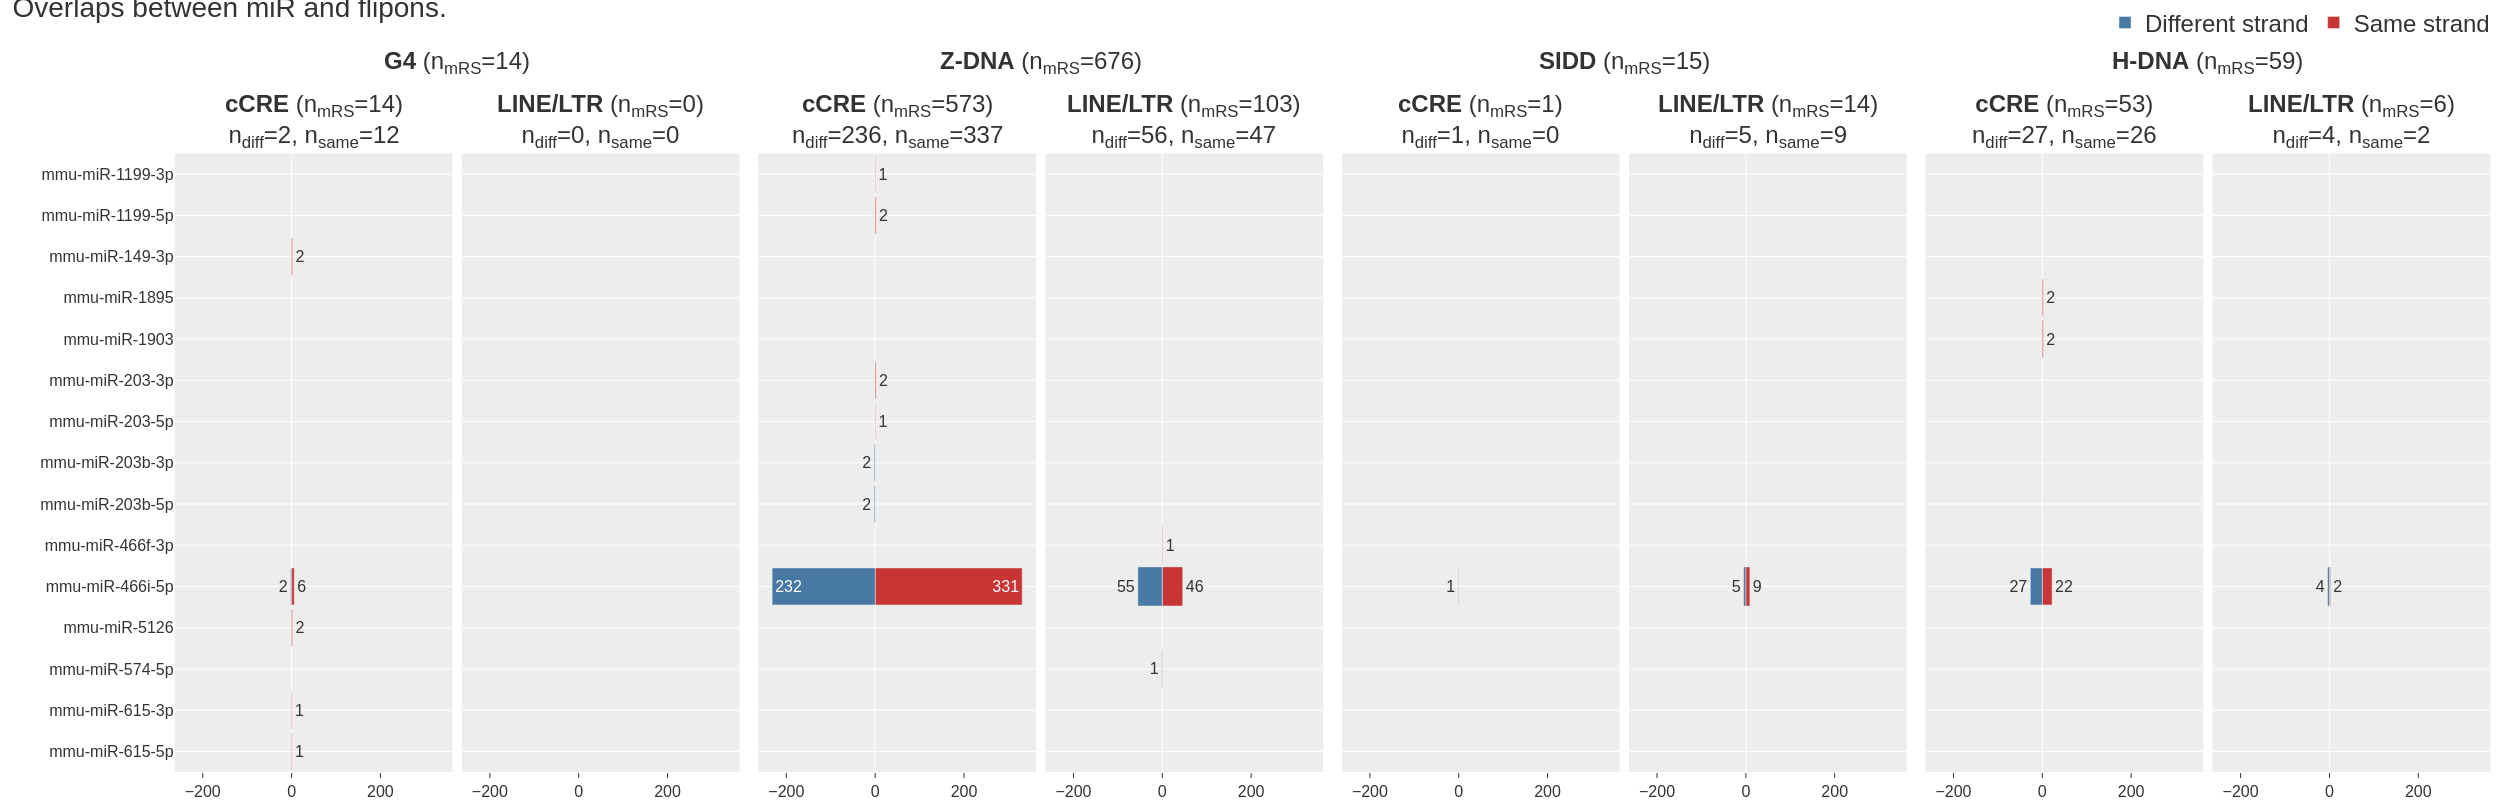

In [72]:
flipon_types = ["g4", "z-dna", "sidd", "h-dna"]
categories_ccre = [
    ("cCRE", "Same strand"),
    ("cCRE", "Different strand"),
]
categories_rmsk = [
    ("LINE/LTR", "Same strand"),
    ("LINE/LTR", "Different strand"),
]
colors = {
    "Same strand": COLORS['SIDD'],
    "Different strand": COLORS['Z-DNA'],
}

n_rows = 2
n_cols = 8

subplot_titles = [
    f"<b>{flipon.upper()}</b> (n<sub>mRS</sub>={mir_count_df[mir_count_df['Flipon']==flipon]['Count'].sum():,d})"
    for flipon in flipon_types
]
for flipon in flipon_types:
    for feature_group, _ in [categories_ccre[0], categories_rmsk[0]]:
        counts_same = mir_count_df[
            (mir_count_df["Flipon"] == flipon) & (mir_count_df["Feature group"]== feature_group) & (mir_count_df['Strand direction']=='Same strand')
        ]["Count"]
        counts_diff = mir_count_df[
            (mir_count_df["Flipon"] == flipon) & (mir_count_df["Feature group"]== feature_group) & (mir_count_df['Strand direction']=='Different strand')
        ]["Count"]
        subplot_titles.append(f"<b>{feature_group}</b> (n<sub>mRS</sub>={counts_same.sum() + counts_diff.sum():,d})<br>n<sub>diff</sub>={counts_diff.sum():,d}, n<sub>same</sub>={counts_same.sum():,d}")

specs = [
    [
        {"colspan": 2},
        None,
        {"colspan": 2},
        None,
        {"colspan": 2},
        None,
        {"colspan": 2},
        None,
    ],
    [{'l':0.002}, {'r':0.002}, {'l':0.002}, {'r':0.002}, {'l':0.002}, {'r':0.002}, {'l':0.002}, {'r':0.002}],
]

fig = ps.make_subplots(
    rows=n_rows,
    cols=n_cols,
    shared_xaxes="all",
    shared_yaxes="all",
    horizontal_spacing=0.004,
    vertical_spacing=0.1,
    subplot_titles=subplot_titles,
    specs=specs,
    row_heights=[.007, .993],
    # y_title="Number of miRNAs per flipon",
    # x_title="Flipon count",
)

for i, flipon in enumerate(flipon_types):
    for category, strand_direction in categories_ccre:
        df = mir_count_df[
            (mir_count_df["Flipon"] == flipon)
            & (mir_count_df["Feature group"] == category)
            & (mir_count_df['Strand direction'] == strand_direction)
        ]
        sub = pgo.Bar(
            x=df["Count signed"],
            y=df["miRNA gene family"],
            text=df["Count"],
            name=strand_direction,
            texttemplate="%{text:,d}",
            textposition=df["Count"].apply(
                lambda x: "outside" if abs(x) <= mir_count_df['Count'].max()/1.5 else "inside"
            ),
            cliponaxis=False,
            marker=dict(color=colors[strand_direction]),
            orientation="h",
            width=0.9,
            showlegend=True if (i == 0) else False,
        )
        fig.add_trace(sub, row=2, col=2 * i + 1)
    for category, strand_direction in categories_rmsk:
        df =  mir_count_df[
            (mir_count_df["Flipon"] == flipon)
            & (mir_count_df["Feature group"] == category)
            & (mir_count_df['Strand direction'] == strand_direction)
        ]
        sub = pgo.Bar(
            x=df["Count signed"],
            y=df["miRNA gene family"],
            text=df["Count"],
            name=strand_direction,
            texttemplate="%{text:,d}",
            textposition=df["Count"].apply(
                lambda x: "outside" if abs(x) <= mir_count_df['Count'].max()/1.5 else "inside"
            ),
            cliponaxis=False,
            marker=dict(color=colors[strand_direction]),
            orientation="h",
            width=0.95,
            showlegend=False,
        )
        fig.add_trace(sub, row=2, col=2 * i + 2)

fig.update_xaxes(tickformat="s", showgrid=False)
fig.update_yaxes(
    ticks="",
    type="category",
    categoryarray=mir_count_df.sort_values("miRNA gene family", ascending=False)["miRNA gene family"].unique(),
    categoryorder="array",
)
fig.update_annotations(font=dict(size=24))

fig.update_layout(
    # title="<span style='font-size: 28px;'>Number of sites bound by each conserved miR by DNA strand (M+MJ+J)</span>",
    title="<span style='font-size: 28px;'>Overlaps between miR and flipons.</span>",
    title_x=0.005,
    title_y=0.998,
    height=500 + mir_count_df['miRNA gene family'].nunique() * 20,
    width=2500,
    barmode="relative",
    font=dict(size=16),
    uniformtext_minsize=16,
    uniformtext_mode="show",
    margin=dict(t=0, r=5, b=5, l=170),
    legend=dict(
        # title_text="Flipon group",
        # traceorder="reversed",
        font_size=24,
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1,
        traceorder='reversed',
    ),
    template="ggplot2",
)

fig.show(renderer='png')
